# Rede Neural para Classificação

**Questão 3 -**  Considere um problema de classificação de padrões constituído de oito padrões. A
distribuição dos padrões forma um círculo centrado na origem de raio unitário e contido no
círculo um losango também centrado na origem e com lados iguais a raiz de 2. Os dados das
classe C1, C2, C3, C4 corresponde aos quatro setores do losango e as outras quatro classes
correspondem aos setores delimitados pelo círculo e os lados do losango. Após gerar
aleatoriamente dados que venham formar estas distribuições de dados, selecione um conjunto
de treinamento e um conjunto de validação. Treine duas redes perceptron (uma rede
utilizando a regra delta convencional, e outra usando a regra delta com termo do
momento), para classificar os padrões associados a cada uma das classes. Verifique o
desempenho dos classificadores usando o conjunto de validação e calculando a matriz de
confusão.

#### Importando Bibliotecas

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from tqdm import tqdm

from data_generator import generate_data
from mlp import MLP

#### Gerando Dados Aleatórios Para o Treinamento

In [2]:
df = generate_data(10000)

In [3]:
df.head()

,x,y,target
0,0.851492,0.004536,0
1,0.188579,0.537194,0
2,0.867618,0.056041,0
3,0.253771,0.145010,0
4,0.764903,0.180301,0


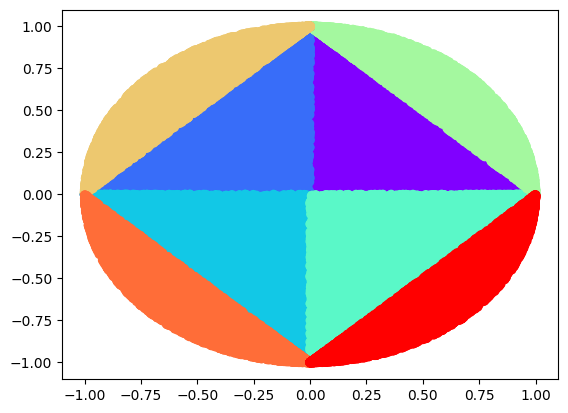

In [4]:
colors = cm.rainbow(np.linspace(0, 1, 8))
plt.scatter(df['x'], df['y'], color=colors[df['target']])

#### Divisão dos Dados Para Treino e Teste

In [5]:
train_X, tmp_X, train_y, tmp_y = train_test_split(df[['x', 'y']].to_numpy(), df['target'].to_numpy(), test_size=0.2, random_state=42)
val_X, test_X, val_y, test_y = train_test_split(tmp_X, tmp_y, test_size=0.5, random_state=42)

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape

((64000, 2), (64000,), (8000, 2), (8000,), (8000, 2), (8000,))

## Treinamento

### Treinamento sem Momento

In [6]:
train_ds = TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_y).long())
val_ds = TensorDataset(torch.from_numpy(val_X).float(), torch.from_numpy(val_y).long())

torch.manual_seed(42)

train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=256)

model_without_momentum = MLP(train_X.shape[1], 8)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_without_momentum.parameters(), lr=0.01, momentum=0.0)

num_epochs = 200
train_losses = [0.] * num_epochs
train_accuracies = [0.] * num_epochs
val_losses = [0.] * num_epochs
val_accuracies = [0.] * num_epochs

for epoch in tqdm(range(num_epochs)):
    for xb, yb in train_dl:
        optimizer.zero_grad()
        pred = model_without_momentum(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()

        train_losses[epoch] += loss.item()
        train_accuracies[epoch] += (pred.argmax(dim=1) == yb).float().sum()

    train_losses[epoch] /= len(train_dl.dataset)
    train_accuracies[epoch] /= len(train_dl.dataset)
    
    for xb, yb in val_dl:
        with torch.no_grad():
            pred = model_without_momentum(xb)
            loss = loss_fn(pred, yb)

            val_losses[epoch] += loss.item()
            val_accuracies[epoch] += (pred.argmax(dim=1) == yb).float().sum()
    
    val_losses[epoch] /= len(val_dl.dataset)
    val_accuracies[epoch] /= len(val_dl.dataset)

100%|██████████| 200/200 [01:22<00:00,  2.43it/s]


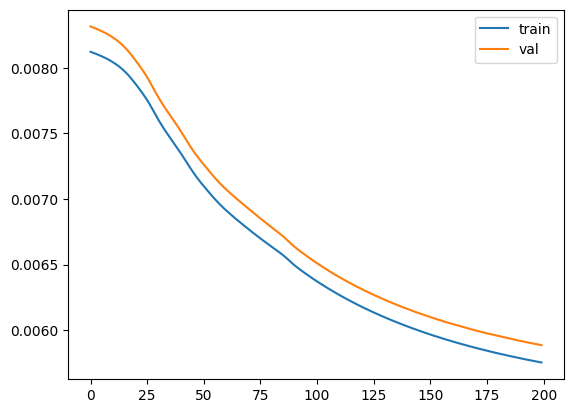

In [7]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()

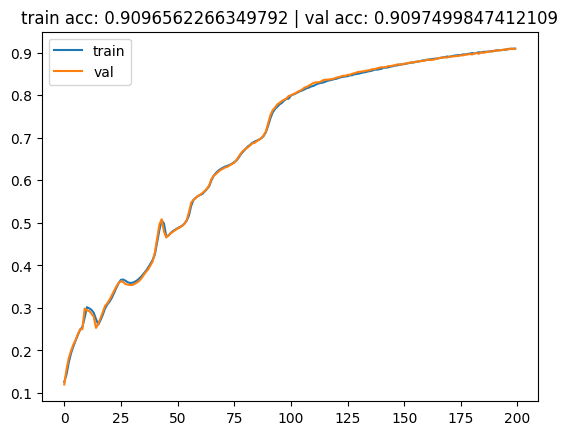

In [8]:
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.title(f'train acc: {train_accuracies[-1]} | val acc: {val_accuracies[-1]}')
plt.legend()

### Treinamento com Momento

In [9]:
train_ds = TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_y).long())
val_ds = TensorDataset(torch.from_numpy(val_X).float(), torch.from_numpy(val_y).long())

torch.manual_seed(42)

train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=256)

model_with_momentum = MLP(train_X.shape[1], 8)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_with_momentum.parameters(), lr=0.01, momentum=0.9)

num_epochs = 200
train_losses = [0.] * num_epochs
train_accuracies = [0.] * num_epochs
val_losses = [0.] * num_epochs
val_accuracies = [0.] * num_epochs

for epoch in tqdm(range(num_epochs)):
    for xb, yb in train_dl:
        optimizer.zero_grad()
        pred = model_with_momentum(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()

        train_losses[epoch] += loss.item()
        train_accuracies[epoch] += (pred.argmax(dim=1) == yb).float().sum()

    train_losses[epoch] /= len(train_dl.dataset)
    train_accuracies[epoch] /= len(train_dl.dataset)
    
    for xb, yb in val_dl:
        with torch.no_grad():
            pred = model_with_momentum(xb)
            loss = loss_fn(pred, yb)

            val_losses[epoch] += loss.item()
            val_accuracies[epoch] += (pred.argmax(dim=1) == yb).float().sum()
    
    val_losses[epoch] /= len(val_dl.dataset)
    val_accuracies[epoch] /= len(val_dl.dataset)

100%|██████████| 200/200 [01:20<00:00,  2.47it/s]


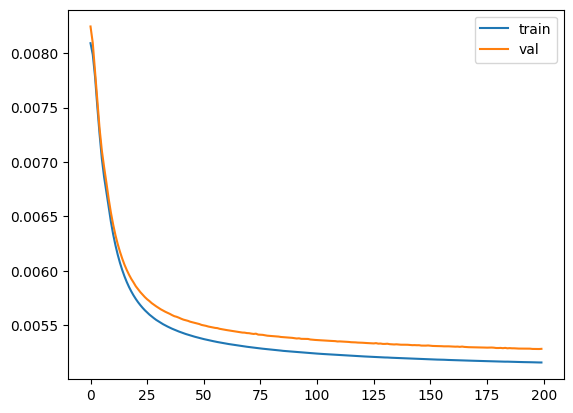

In [10]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()

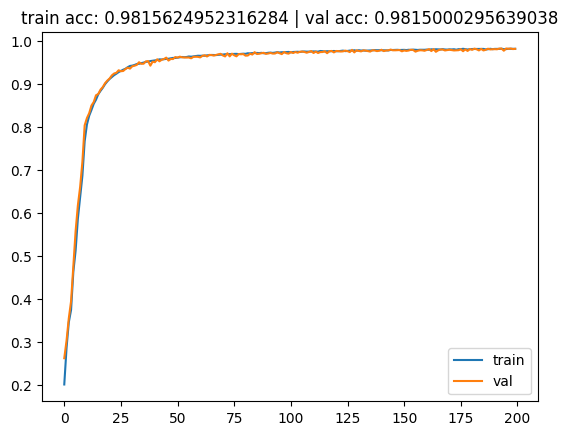

In [11]:
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.title(f'train acc: {train_accuracies[-1]} | val acc: {val_accuracies[-1]}')
plt.legend()

## Testando as Redes

### Sem Momento

In [17]:
y_pred = []
for x in tqdm(test_X):
    with torch.no_grad():
        pred = model_without_momentum(torch.from_numpy(x).reshape(1, -1).float())
        y_pred.append(pred.argmax().item())

100%|██████████| 8000/8000 [00:00<00:00, 39378.10it/s]


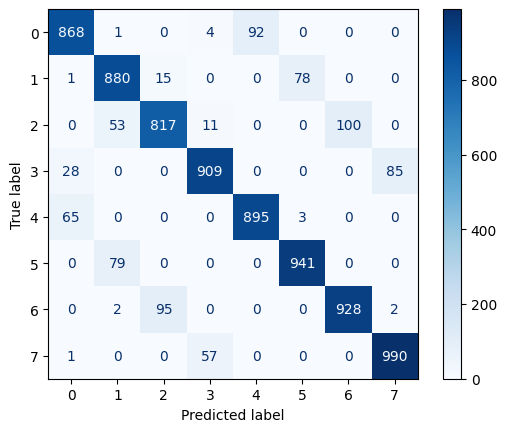

In [18]:
ConfusionMatrixDisplay.from_predictions(test_y, y_pred, cmap=plt.cm.Blues)

In [19]:
accuracy_score(test_y, y_pred)

0.9035

### Com Momento

In [20]:
y_pred = []
for x in tqdm(test_X):
    with torch.no_grad():
        pred = model_with_momentum(torch.from_numpy(x).reshape(1, -1).float())
        y_pred.append(pred.argmax(dim=1).item())

100%|██████████| 8000/8000 [00:00<00:00, 42460.21it/s]


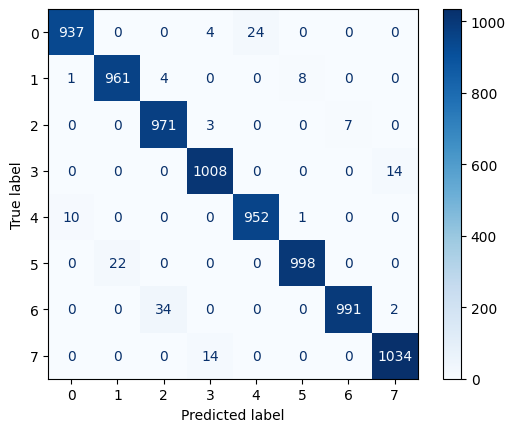

In [21]:
ConfusionMatrixDisplay.from_predictions(test_y, y_pred, cmap=plt.cm.Blues)

In [22]:
accuracy_score(test_y, y_pred)

0.9815